In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
from pymc.model.transform.optimization import freeze_dims_and_data

from pymc_marketing.mmm import GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.multidimensional import MMM

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
MMM

pymc_marketing.mmm.multidimensional.MMM

In [4]:
GeometricAdstock

pymc_marketing.mmm.components.adstock.GeometricAdstock

In [5]:
# Generate a date range
date_range = pd.date_range(start="2023-01-01", end="2023-01-10")

# Define countries and channels
countries = ["Venezuela", "Colombia", "Chile", "Argentina"]
channels = ["a", "b"]

# Create a DataFrame
data = []
for country in countries:
    for date in date_range:
        record = [date, country, *list(np.random.randint(100, 500, size=len(channels)))]
        data.append(record)

df = pd.DataFrame(data, columns=["date", "country", *channels])
df["target"] = df[channels].sum(axis=1) + np.random.randint(100, 500, size=len(df))
df.head()

,date,country,a,b,target
0,2023-01-01,Venezuela,444,387,1106
1,2023-01-02,Venezuela,186,346,738
2,2023-01-03,Venezuela,104,490,790
3,2023-01-04,Venezuela,221,468,825
4,2023-01-05,Venezuela,136,480,913


In [6]:
from pymc_marketing.prior import Prior

# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

# Not working with hierarchical priors

In [7]:
# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

saturation = MichaelisMentenSaturation(priors=priors)

In [8]:
saturation.model_config

{'saturation_alpha': Prior("Gamma", mu=Prior("HalfNormal", sigma=1, dims="country"), sigma=Prior("HalfNormal", sigma=1, dims="country"), dims=("channel", "country")),
 'saturation_lam': Prior("HalfNormal", sigma=1, dims="channel")}

In [9]:
alpha = Prior("HalfNormal", sigma=1, dims="channel")
adstock = GeometricAdstock(l_max=2)
adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=1, beta=3)}

In [10]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    dims=("country",),
    adstock=GeometricAdstock(l_max=2),
    saturation=MichaelisMentenSaturation(priors=priors),
    yearly_seasonality=12,
    time_varying_media=True,
    time_varying_intercept=True,
)

In [11]:
mmm.build_model(X=df.drop(columns="target"), y=df.drop(columns=channels))

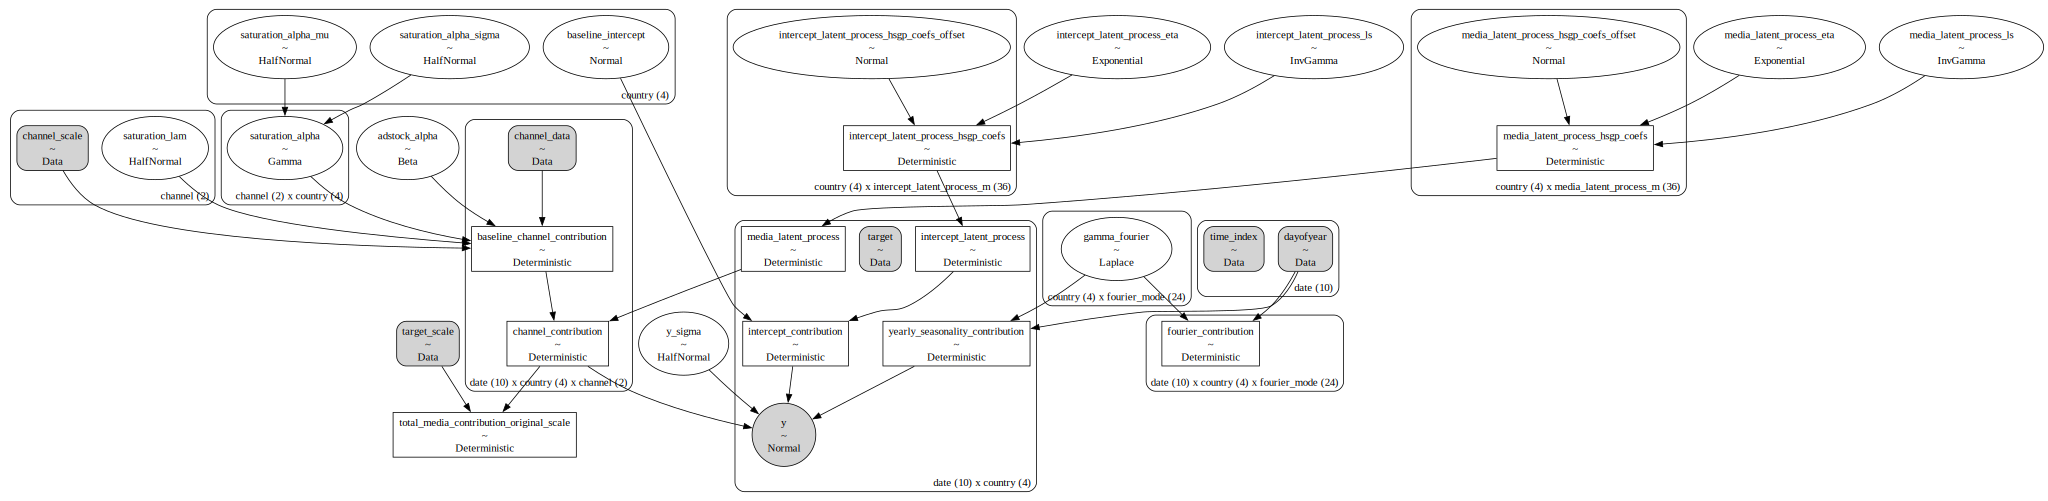

In [12]:
pm.model_to_graphviz(mmm.model)

In [33]:
mmm.add_original_scale_contribution_variable(
    var=["intercept_contribution", "channel_contribution"]
)

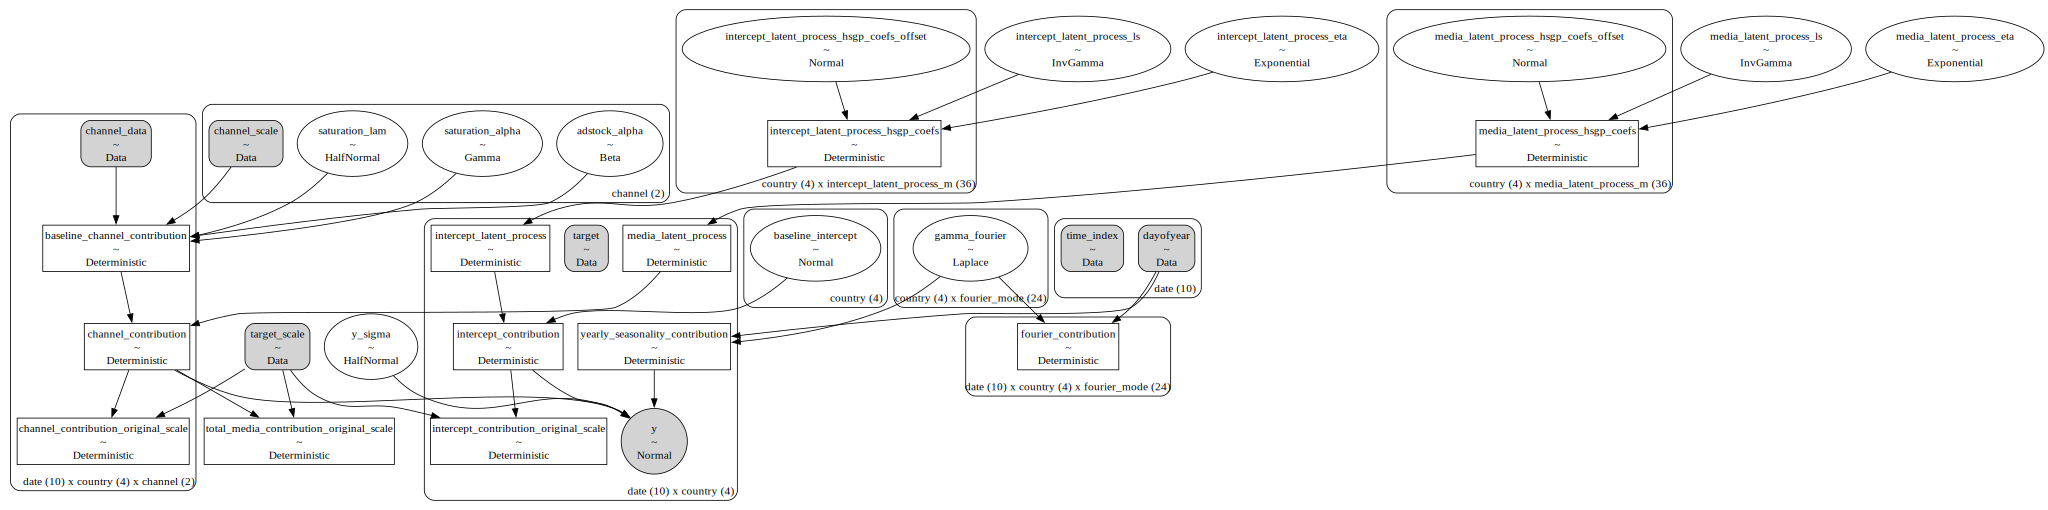

In [34]:
pm.model_to_graphviz(mmm.model)

In [35]:
pytensor.dprint(
    freeze_dims_and_data(mmm.model)["channel_contribution_original_scale"],
    depth=4,
    print_type=True,
)

Mul [id A] <Tensor3(float64, shape=(10, 4, 2))> 'channel_contribution_original_scale'
 ├─ Mul [id B] <Tensor3(float64, shape=(10, 4, 2))> 'channel_contribution'
 │  ├─ True_div [id C] <Tensor3(float64, shape=(10, 4, 2))> 'baseline_channel_contribution'
 │  │  ├─ Mul [id D] <Tensor3(float64, shape=(10, 4, 2))>
 │  │  └─ Add [id E] <Tensor3(float64, shape=(10, 4, 2))>
 │  └─ ExpandDims{axis=2} [id F] <Tensor3(float64, shape=(10, 4, 1))>
 │     └─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id G] <Matrix(float64, shape=(10, 4))> 'media_latent_process'
 └─ ExpandDims{axes=[0, 1, 2]} [id H] <Tensor3(float64, shape=(1, 1, 1))>
    └─ target_scale{1203.0} [id I] <Scalar(float64, shape=())>


In [36]:
mmm.fit(
    X=df.drop(columns="target"),
    y=df.drop(columns=channels),
    chains=4,
    target_accept=0.85,
    nuts_sampler="numpyro",
)

mmm.sample_posterior_predictive(X=df.drop(columns="target"), y=None)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2025-01-30 21:29:23.616088: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.11 = f64[4,1000,10,4,2]{4,3,2,1,0} reduce(f64[4,1000,1,10,4,2]{5,4,3,2,1,0} %broadcast.14, f64[] %constant.29), dimensions={2}, to_apply=%region_7.203, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod" source_file="/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/tmp1cc_5nlt" source_line=143}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-01-30 21:29:23.934906: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.32383s
Constant folding an instruction is taking >

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

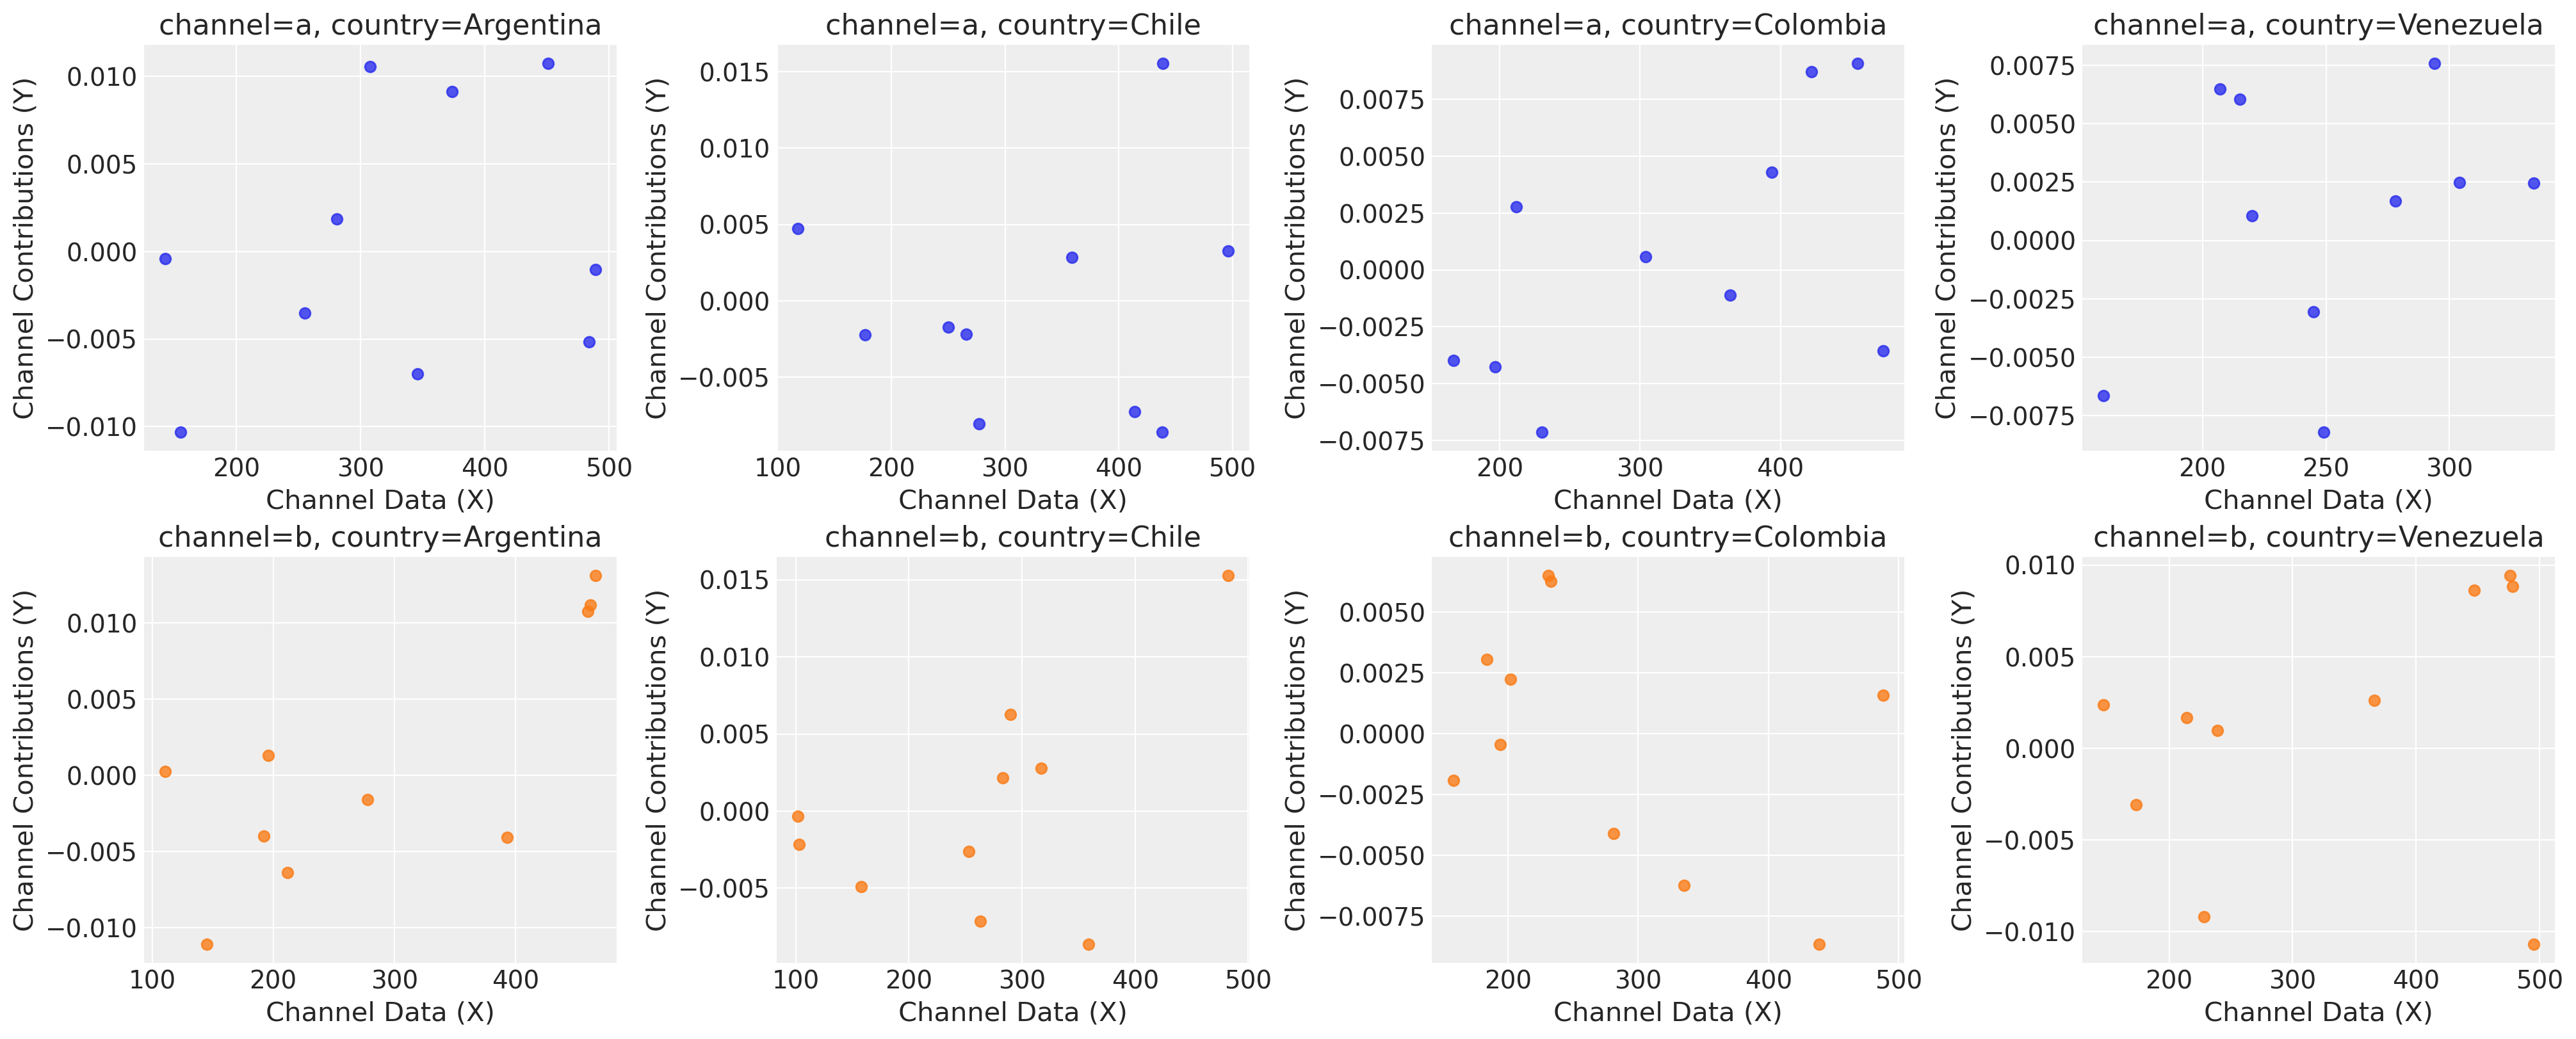

In [37]:
mmm.plot_saturation_curves_scatter();

In [59]:
_y_in_sample = mmm.sample_posterior_predictive(
    X=df.drop(columns="target"), y=None, extend_idata=False
)

Sampling: [y]


Output()

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:512: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


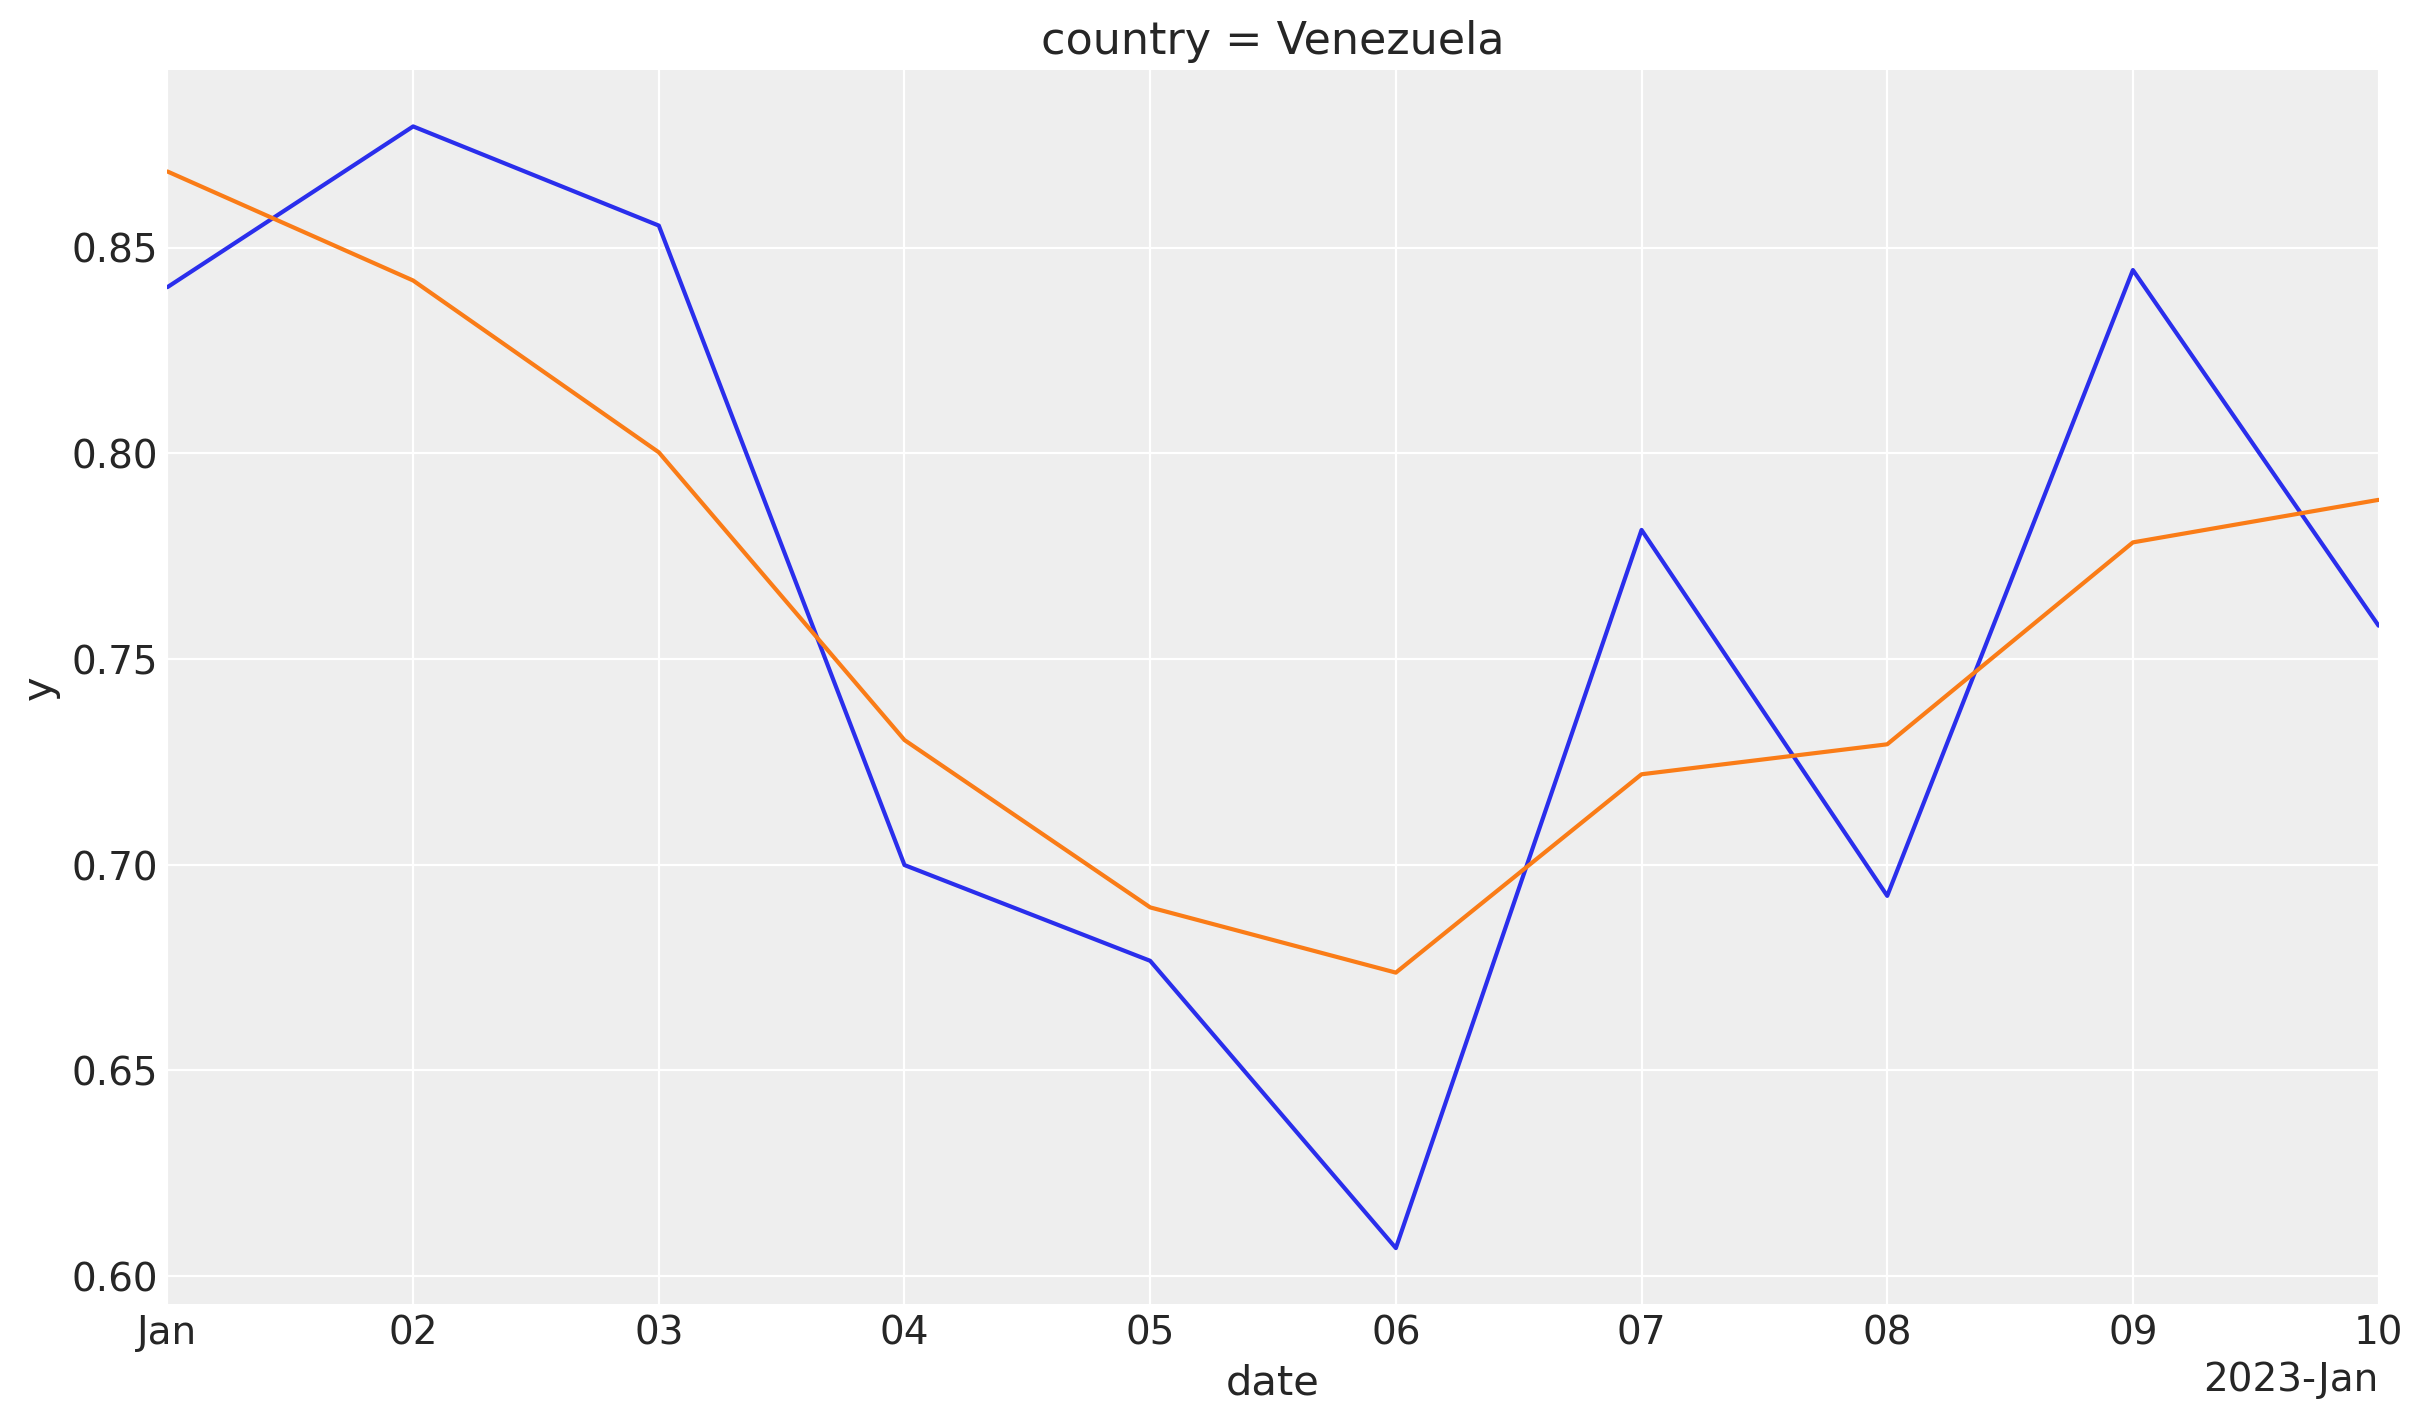

In [72]:
(df[df.country == "Venezuela"].set_index(["date"]).target / df.target.max()).plot()
mmm.idata.posterior_predictive.y.mean(dim=["chain", "draw"]).sel(
    country="Venezuela"
).plot();

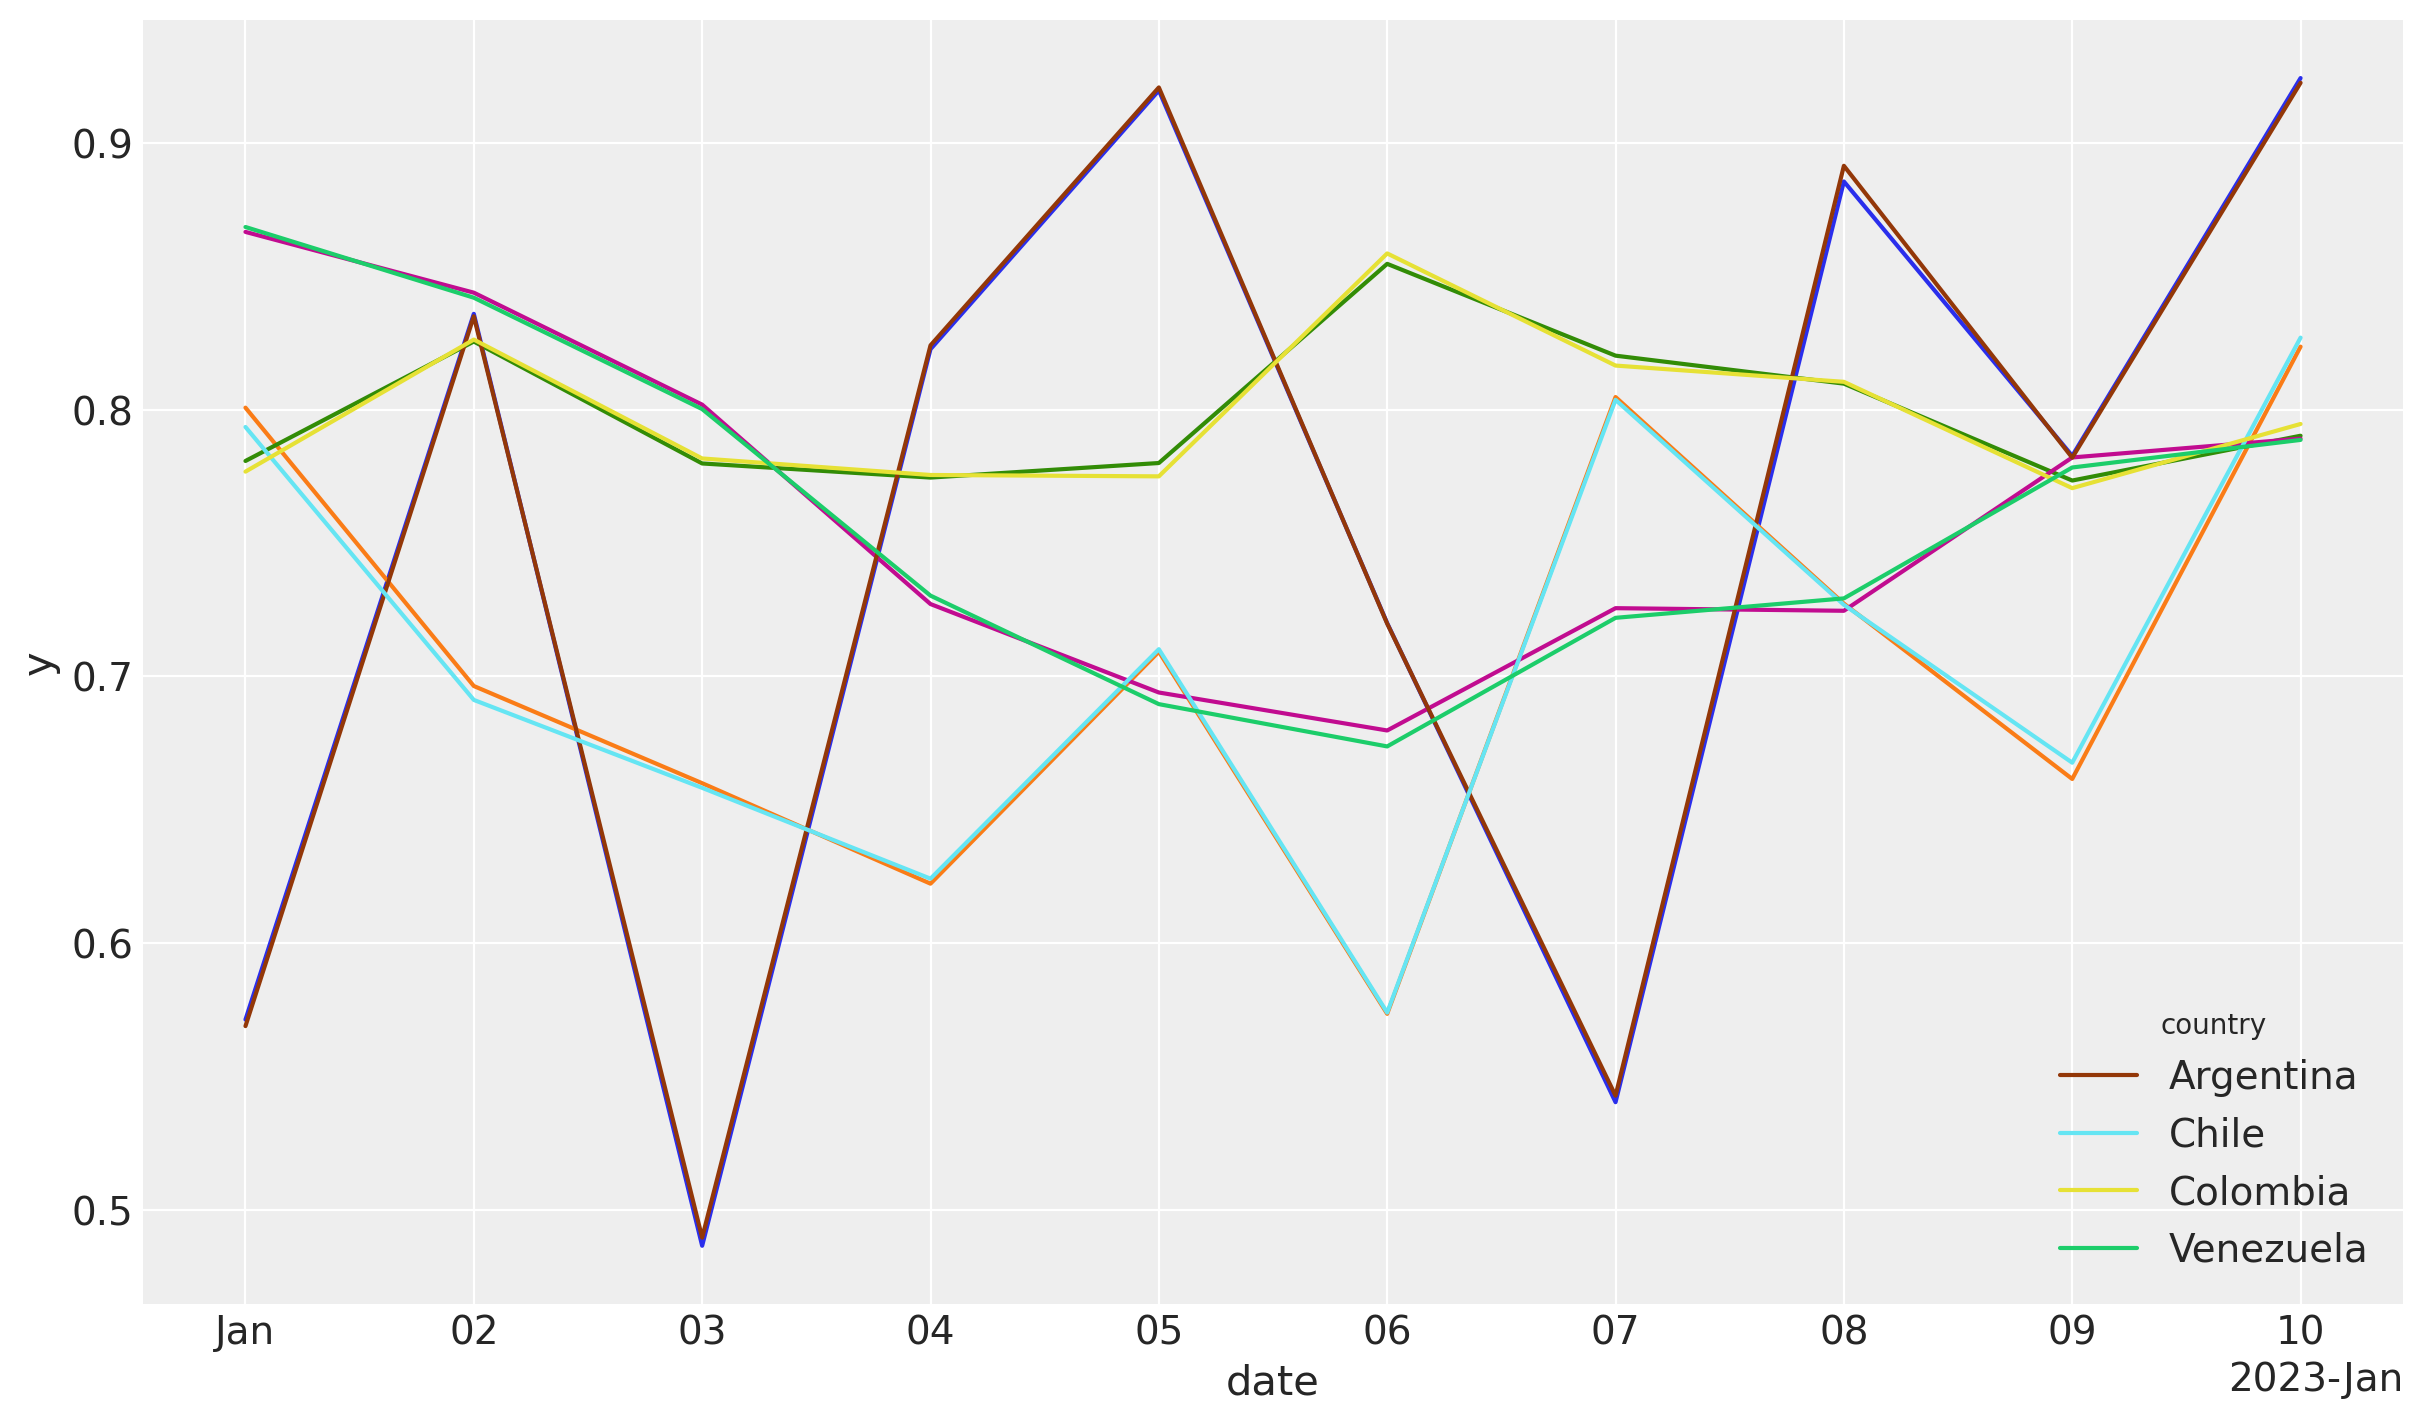

In [73]:
_y_in_sample.y.mean(dim="sample").plot(hue="country")
mmm.idata.posterior_predictive.y.mean(dim=["chain", "draw"]).plot(hue="country");

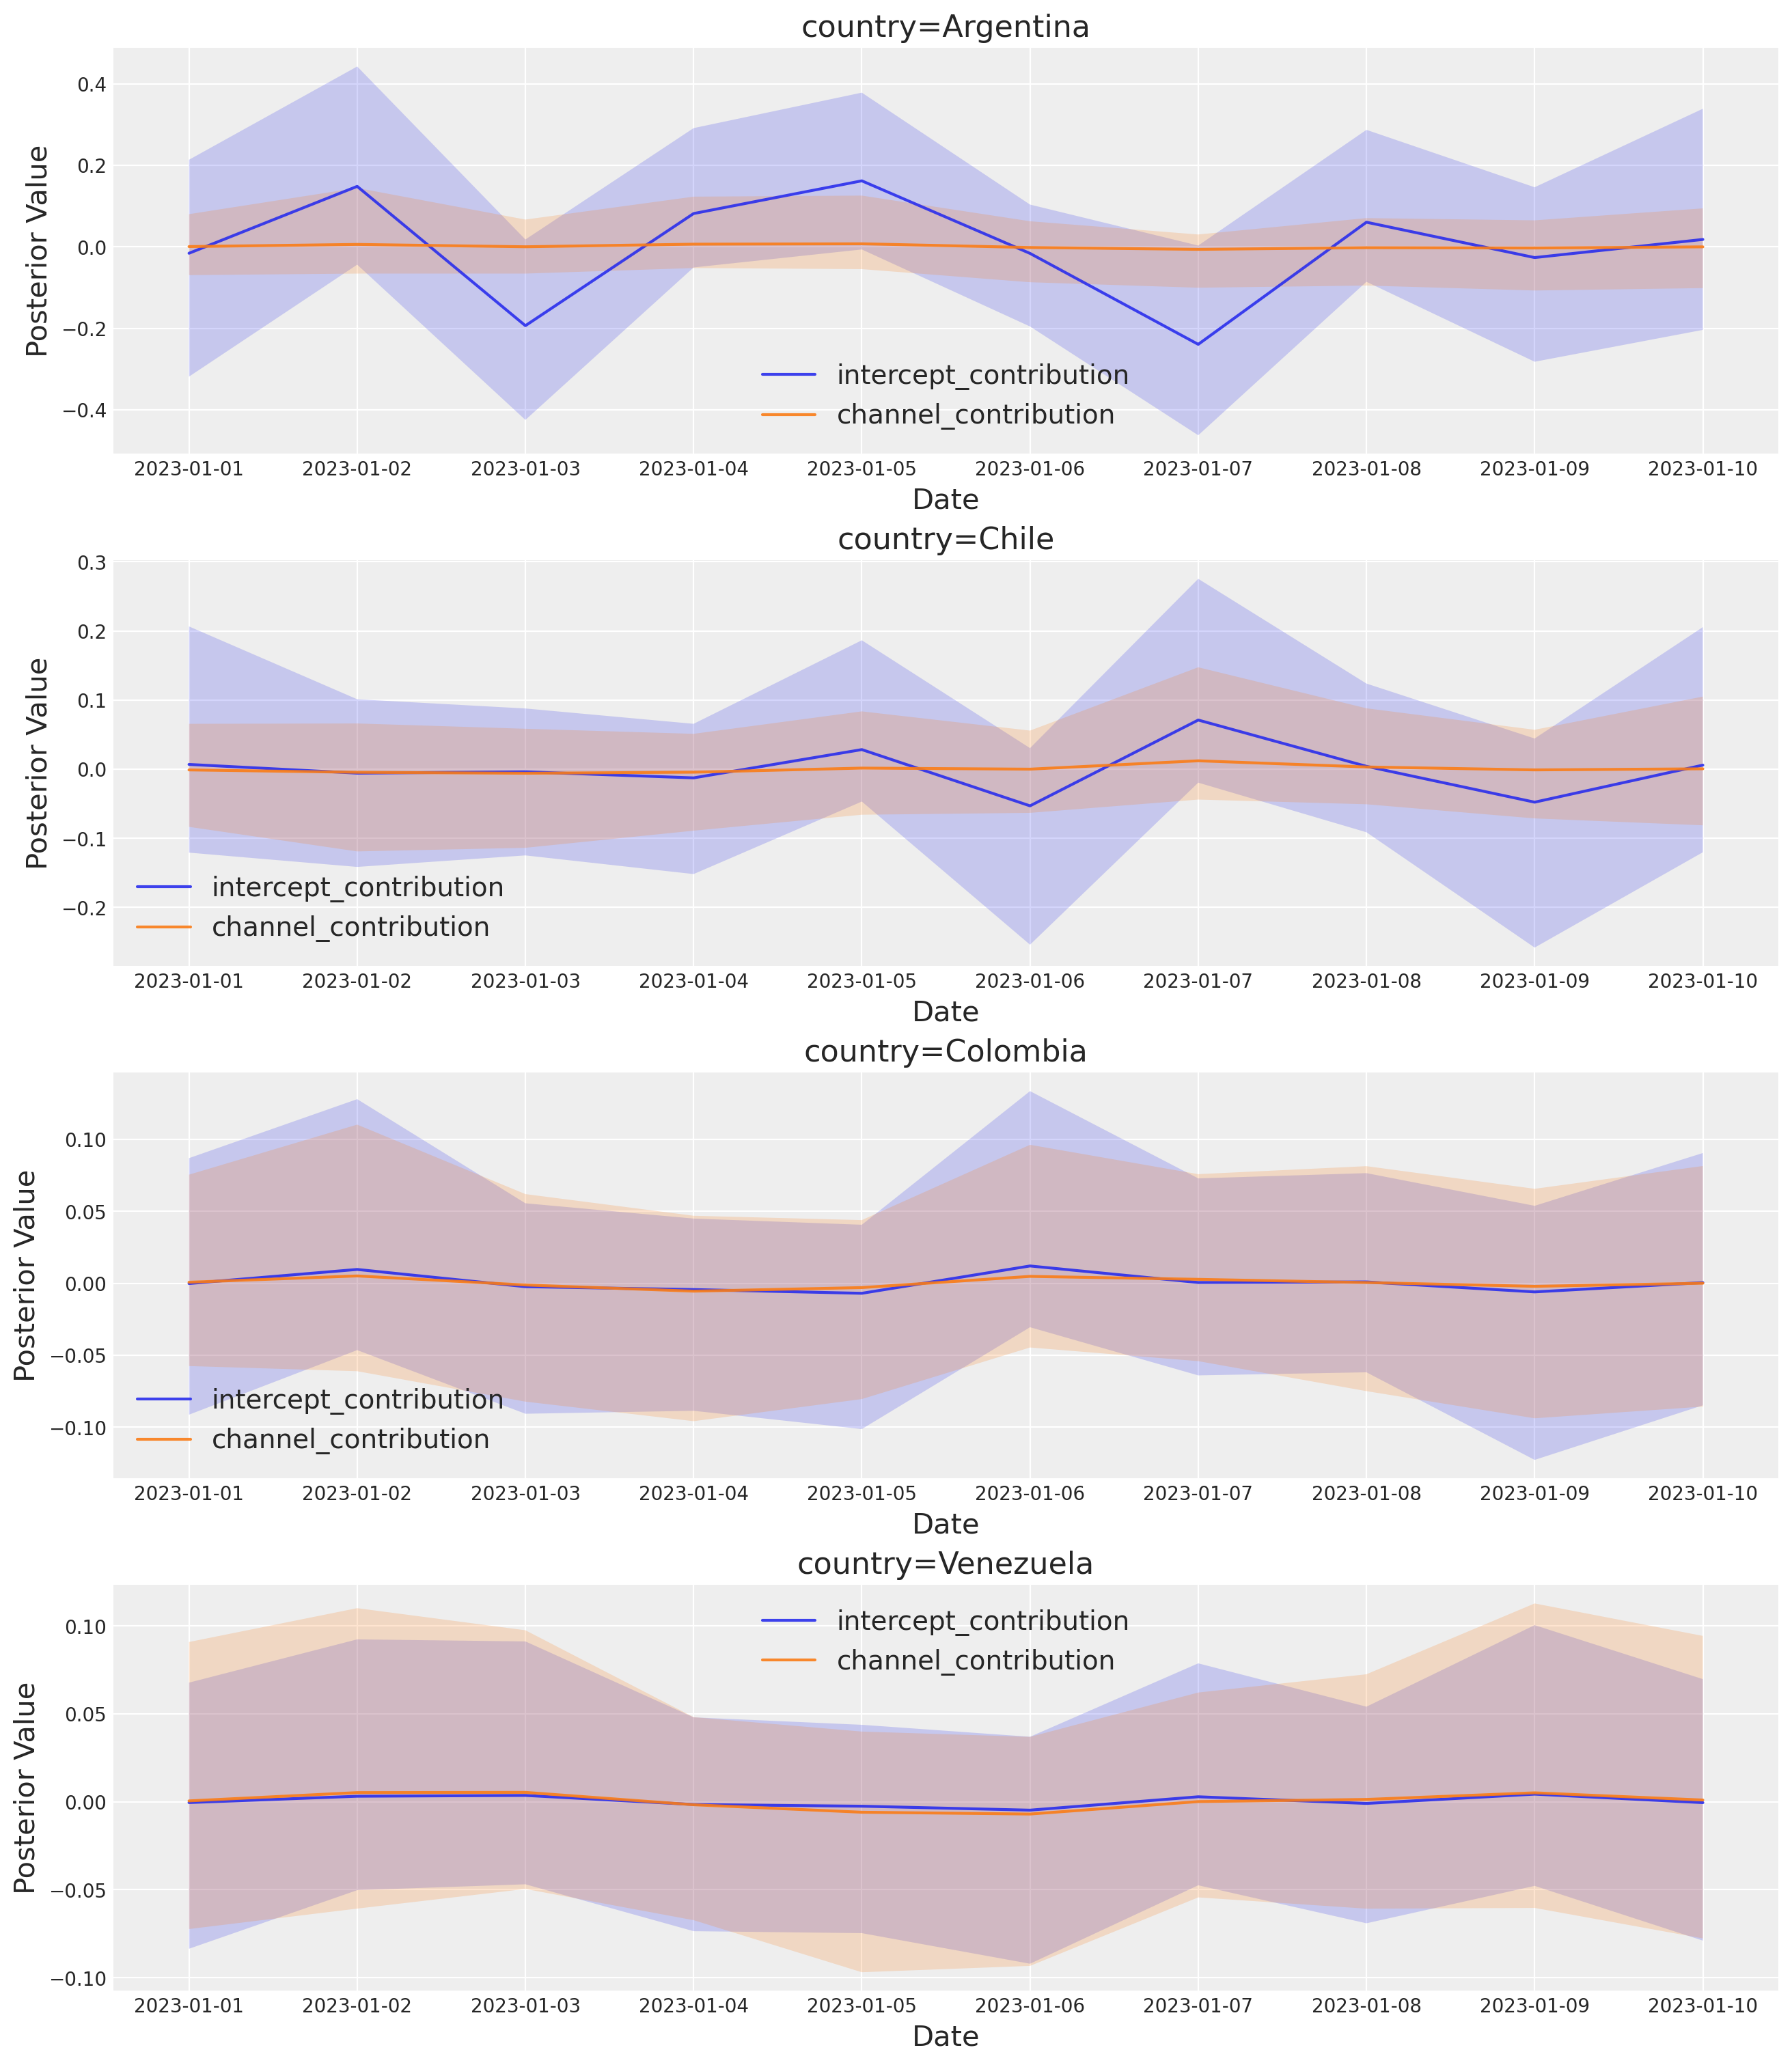

In [84]:
fig, ax = mmm.plot_contributions_over_time(
    var=["intercept_contribution", "channel_contribution"],
    ci=0.85,
)
fig.set_size_inches(13, 15)

# Change the size of the axis letters to be smaller
for axis in ax.flatten():
    axis.tick_params(axis="both", which="major", labelsize=10)
    axis.tick_params(axis="both", which="minor", labelsize=8)

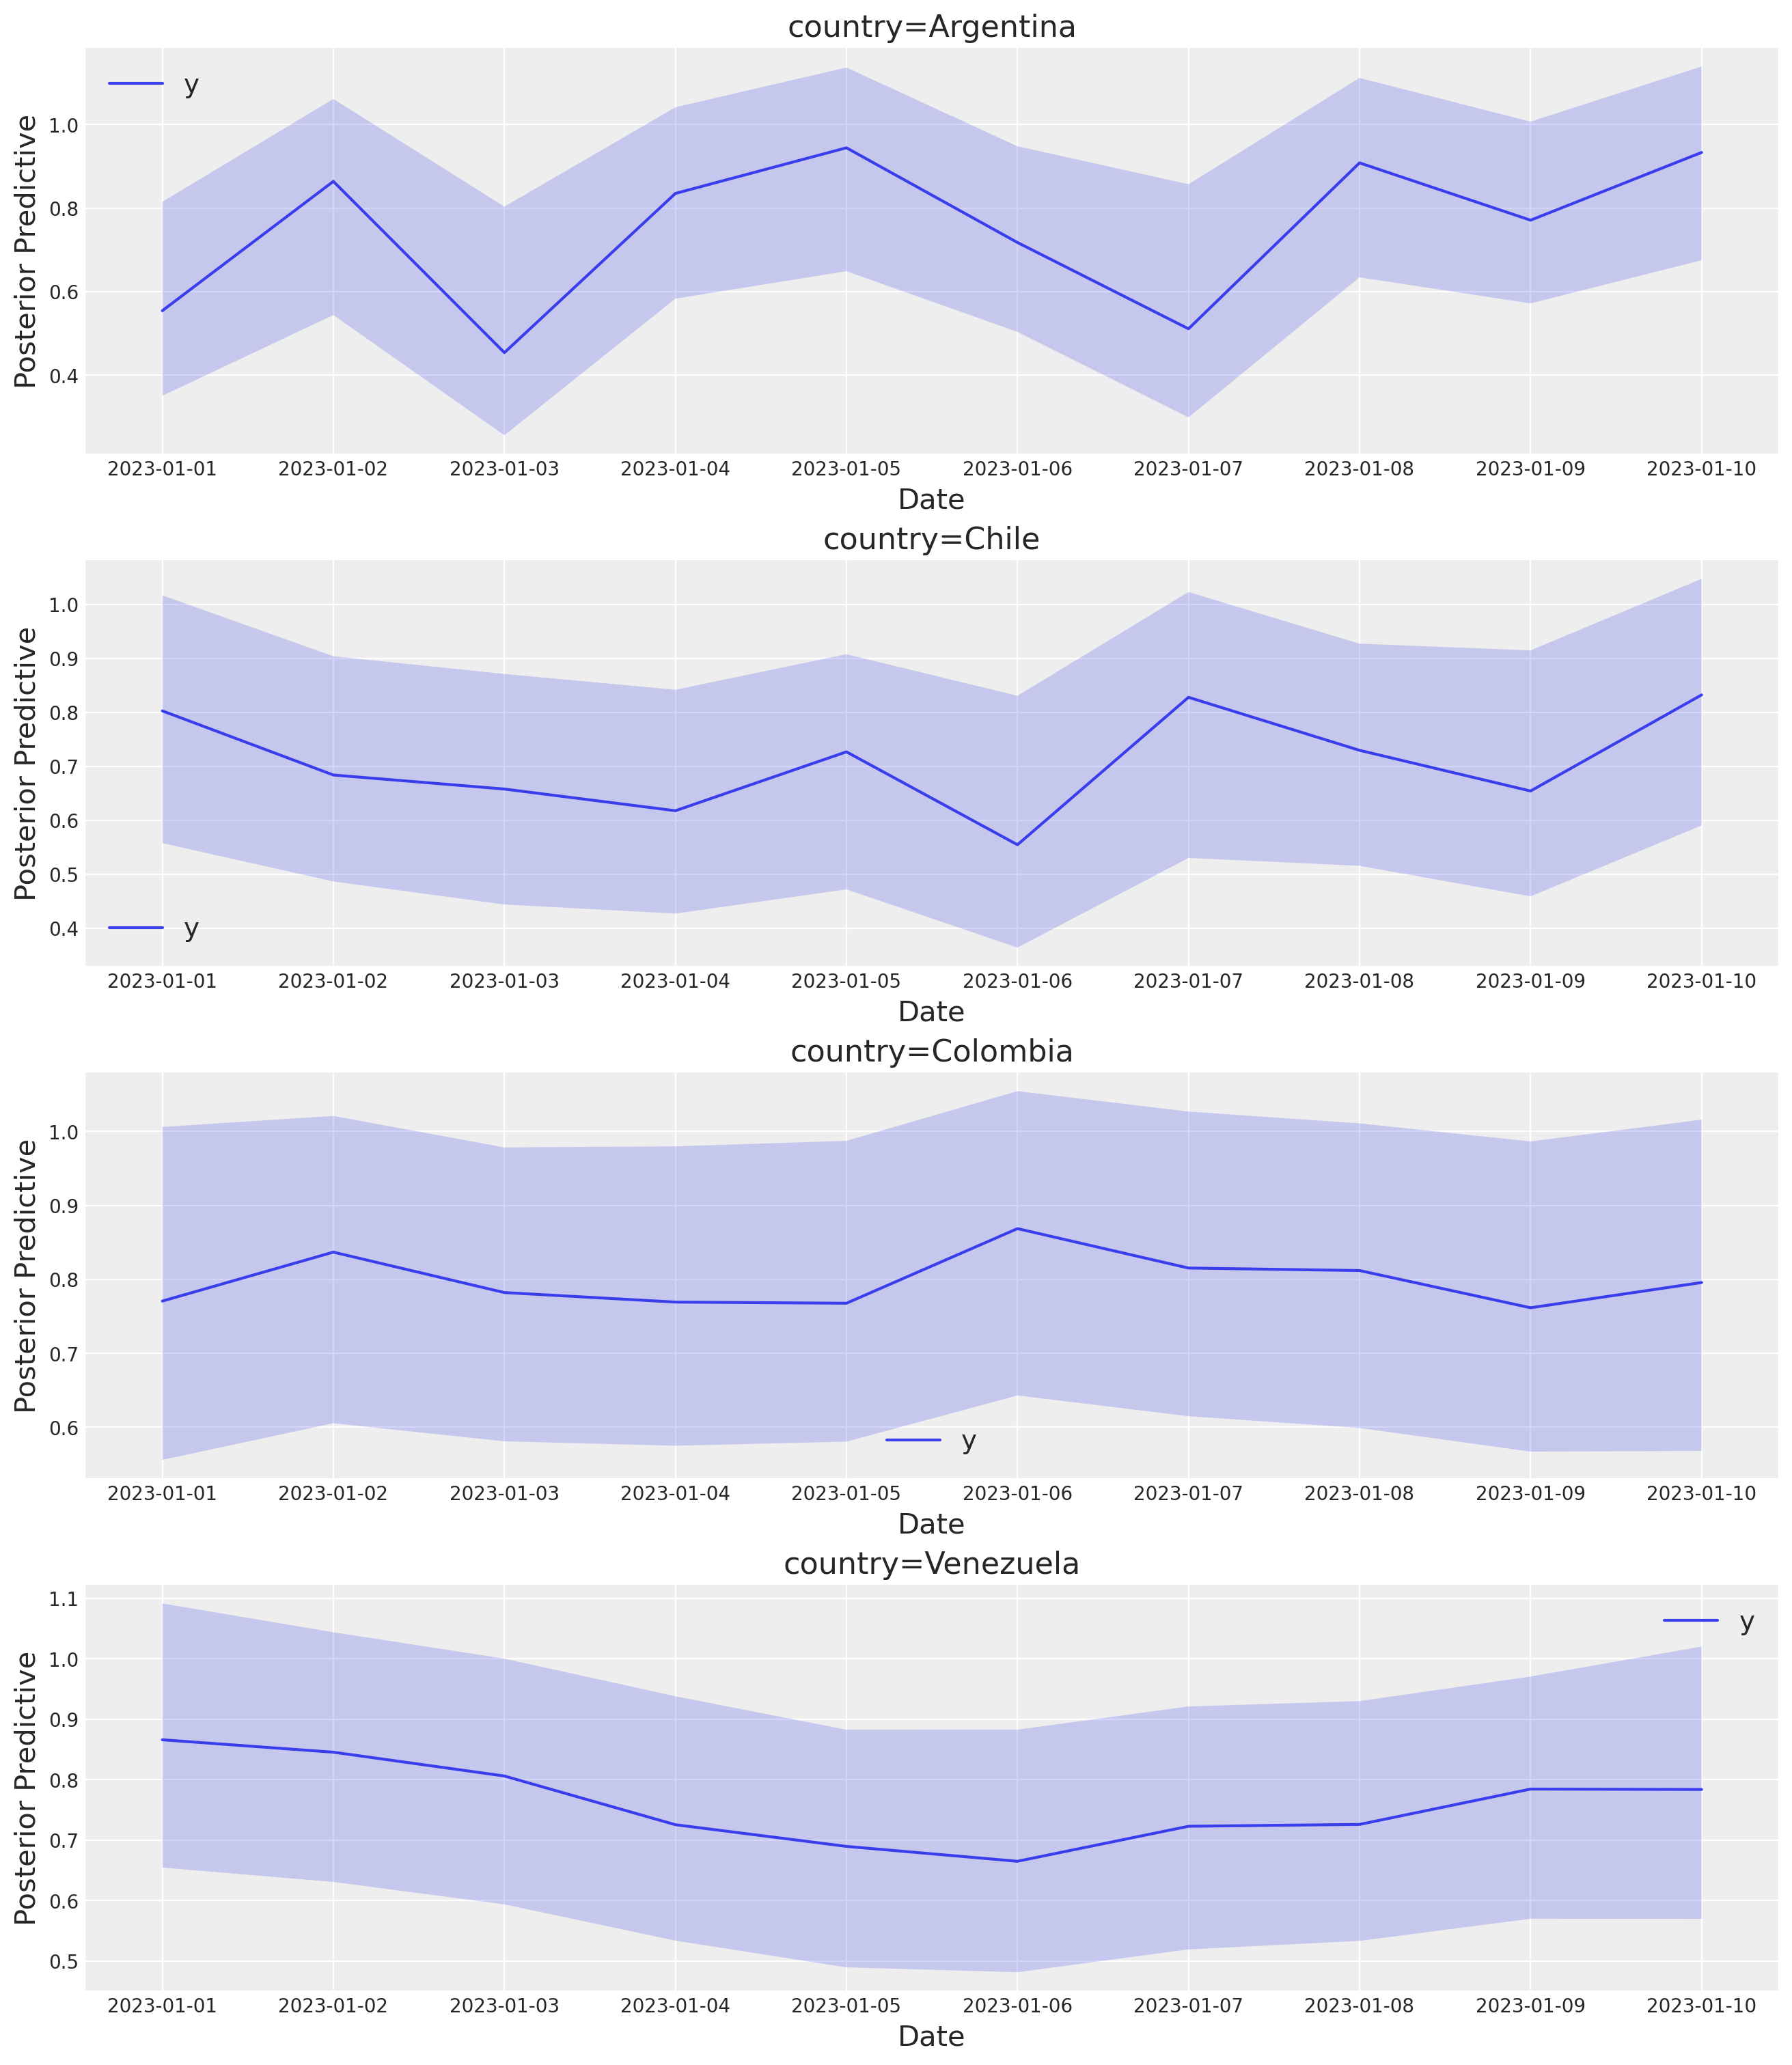

In [86]:
fig, ax = mmm.plot_posterior_predictive()
fig.set_size_inches(13, 15)

# Change the size of the axis letters to be smaller
for axis in ax.flatten():
    axis.tick_params(axis="both", which="major", labelsize=10)
    axis.tick_params(axis="both", which="minor", labelsize=8)

In [42]:
mmm.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [43]:
mmm.idata.posterior[["saturation_alpha", "saturation_lam"]]

<xarray.Dataset> Size: 136kB
Dimensions:           (chain: 4, draw: 1000, channel: 2)
Coordinates:
  * chain             (chain) int64 32B 0 1 2 3
  * draw              (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * channel           (channel) <U1 8B 'a' 'b'
Data variables:
    saturation_alpha  (chain, draw, channel) float64 64kB 1.005 0.6217 ... 2.972
    saturation_lam    (chain, draw, channel) float64 64kB 0.7395 ... 0.1244
Attributes:
    created_at:                 2025-01-30T19:29:24.007476+00:00
    arviz_version:              0.20.0
    inference_library:          numpyro
    inference_library_version:  0.16.1
    sampling_time:              34.357489
    tuning_steps:               1000

In [44]:
mmm.saturation

MichaelisMentenSaturation(prefix='saturation', priors={'alpha': Prior("Gamma", mu=2, sigma=1, dims="channel"), 'lam': Prior("HalfNormal", sigma=1, dims="channel")})

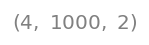

In [45]:
mmm.saturation.function(
    x=3,
    lam=mmm.idata.posterior["saturation_lam"].values,
    alpha=mmm.idata.posterior["saturation_alpha"].values,
).eval().shape

Sampling: []


Output()

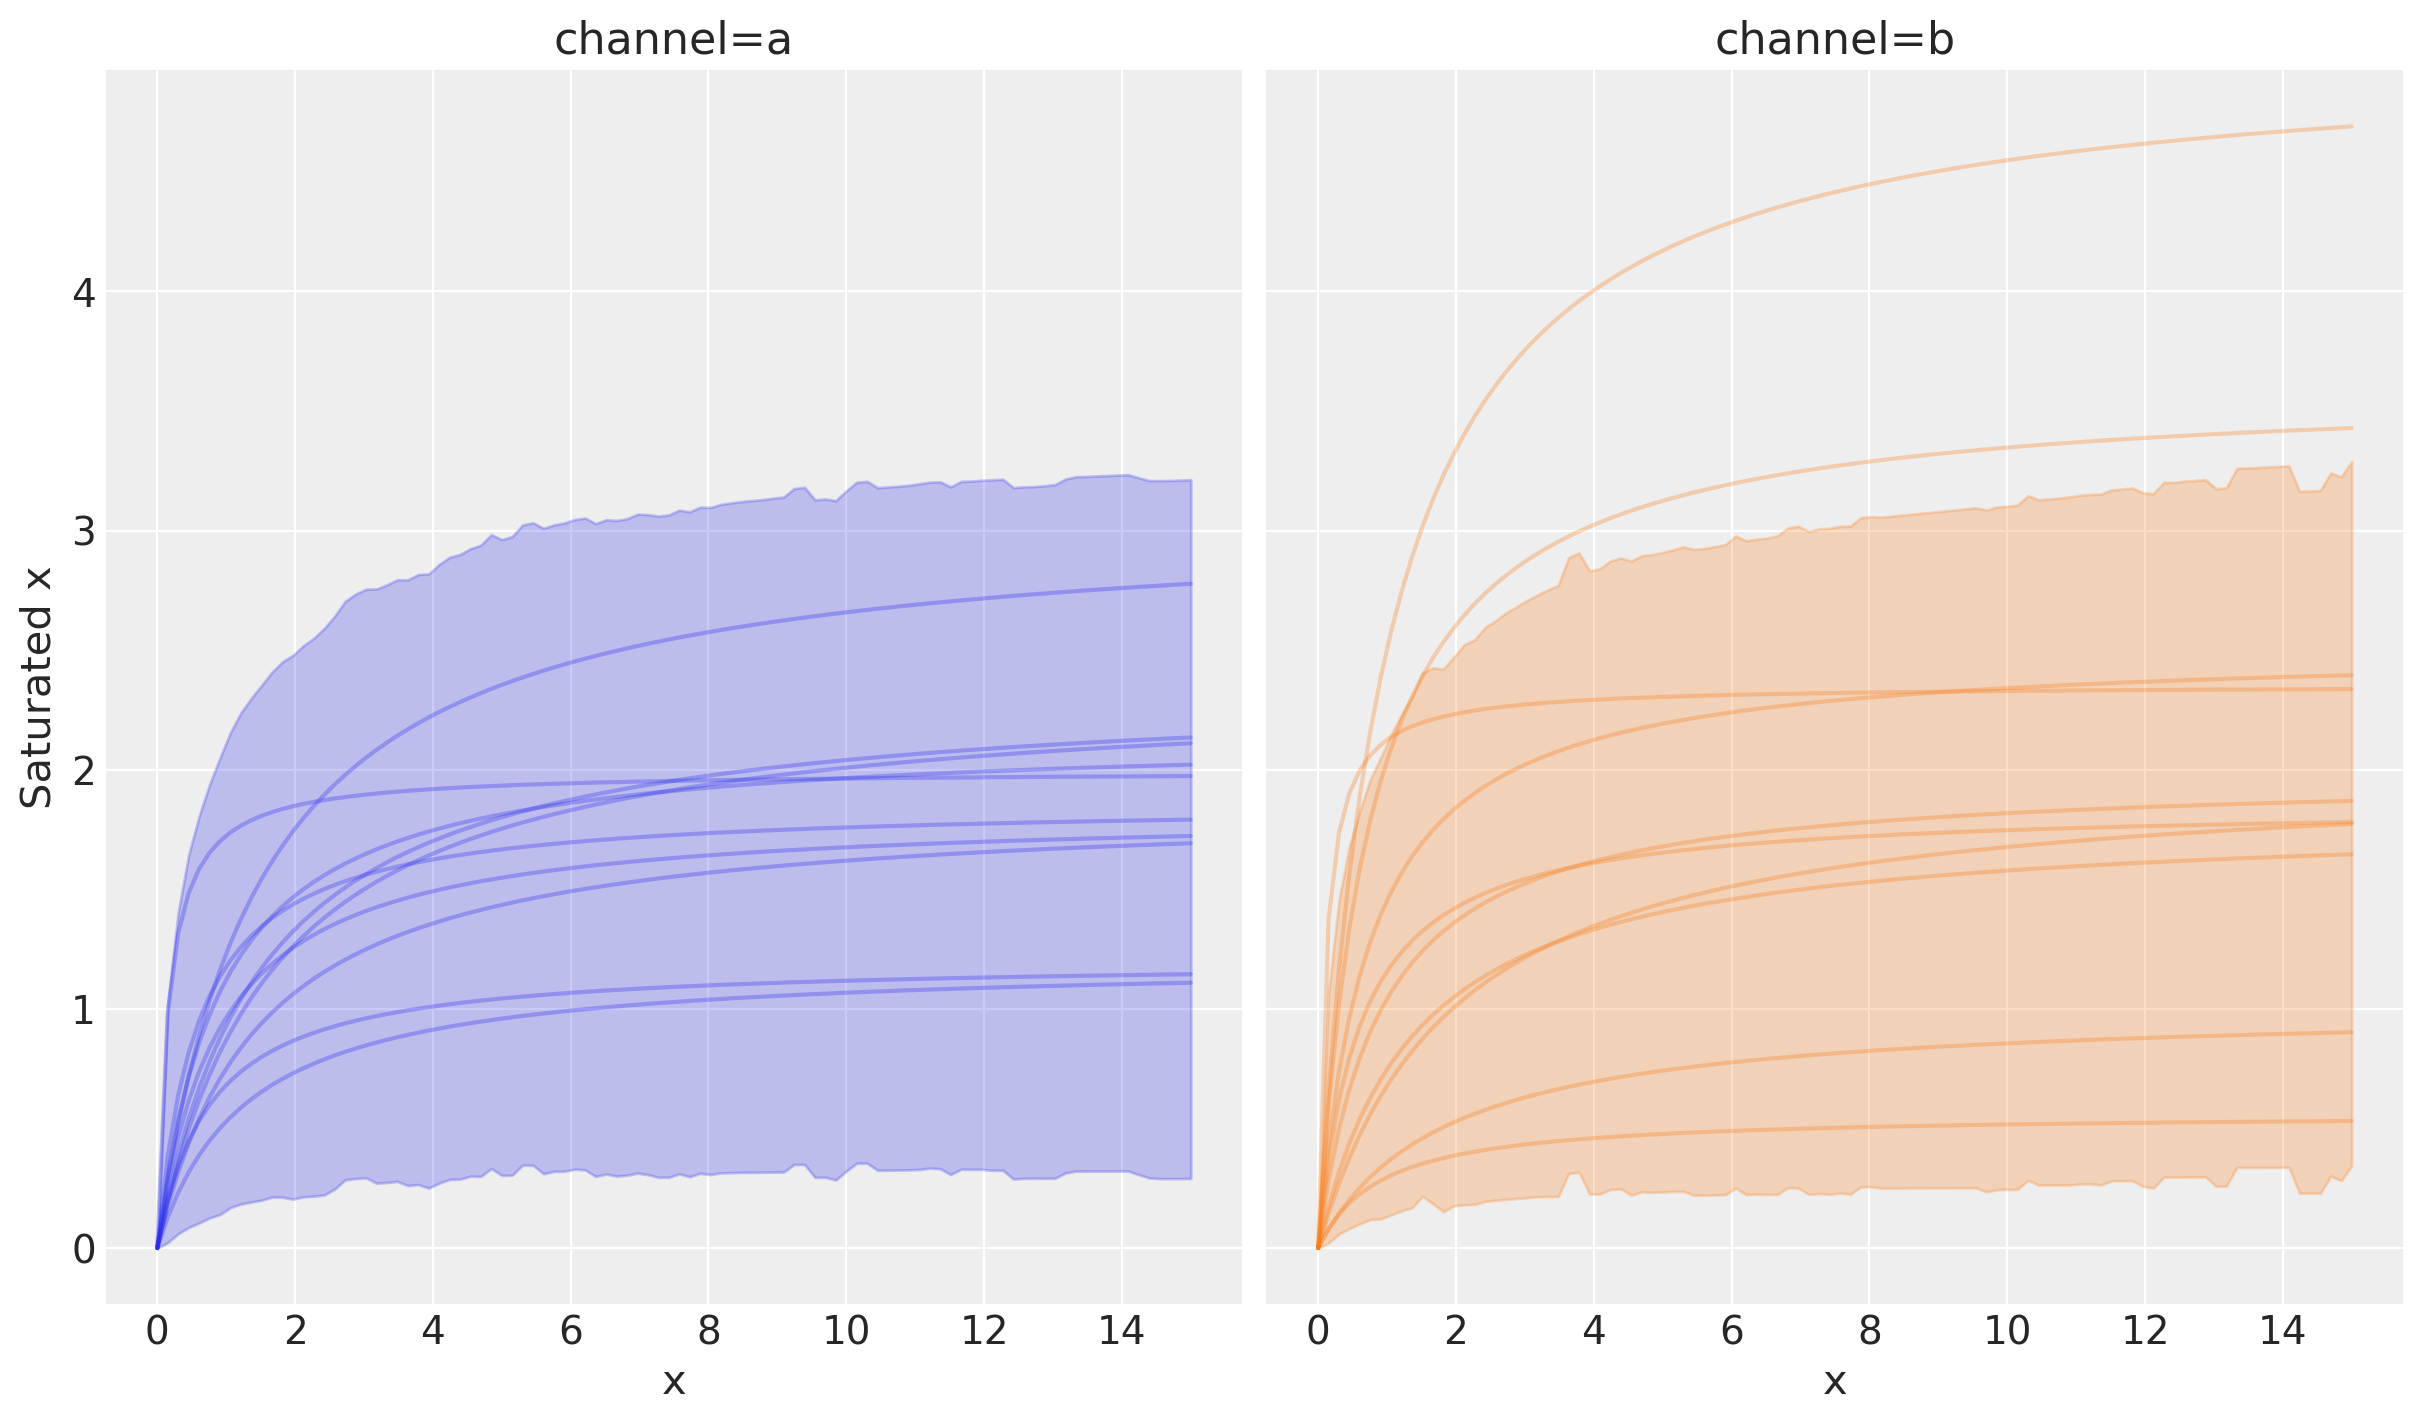

In [46]:
# mmm.saturation.plot_curve(curve=mmm.idata.posterior[["saturation_lam","saturation_beta"]]);

curve = mmm.saturation.sample_curve(
    mmm.idata.posterior[
        [var for var in mmm.idata.posterior.data_vars if var.startswith("saturation_")]
    ],
    max_value=15,
)
_, axes = mmm.saturation.plot_curve(curve)
axes[0].set(
    ylabel="Saturated x",
    # title="Posterior Saturation Curve",
);

In [19]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    # dims=("country",),
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
)

# df.drop(columns="country", inplace=True)

In [20]:
mmm.fit(
    X=df.drop(columns=["country", "target"]), y=df.drop(columns=[*channels, "country"])
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_alpha, saturation_lam, y_sigma]
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 371 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

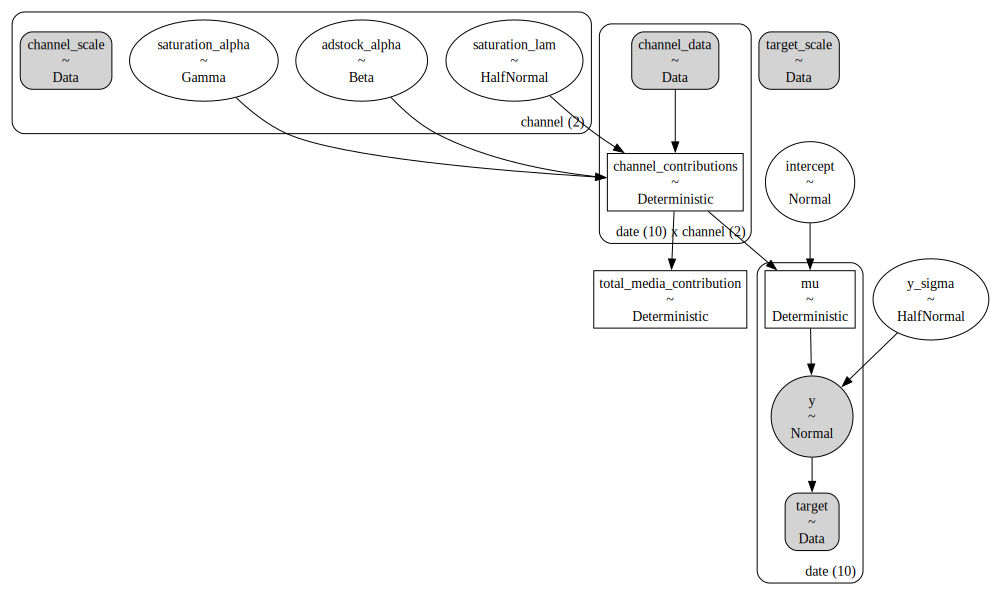

In [21]:
pm.model_to_graphviz(mmm.model)

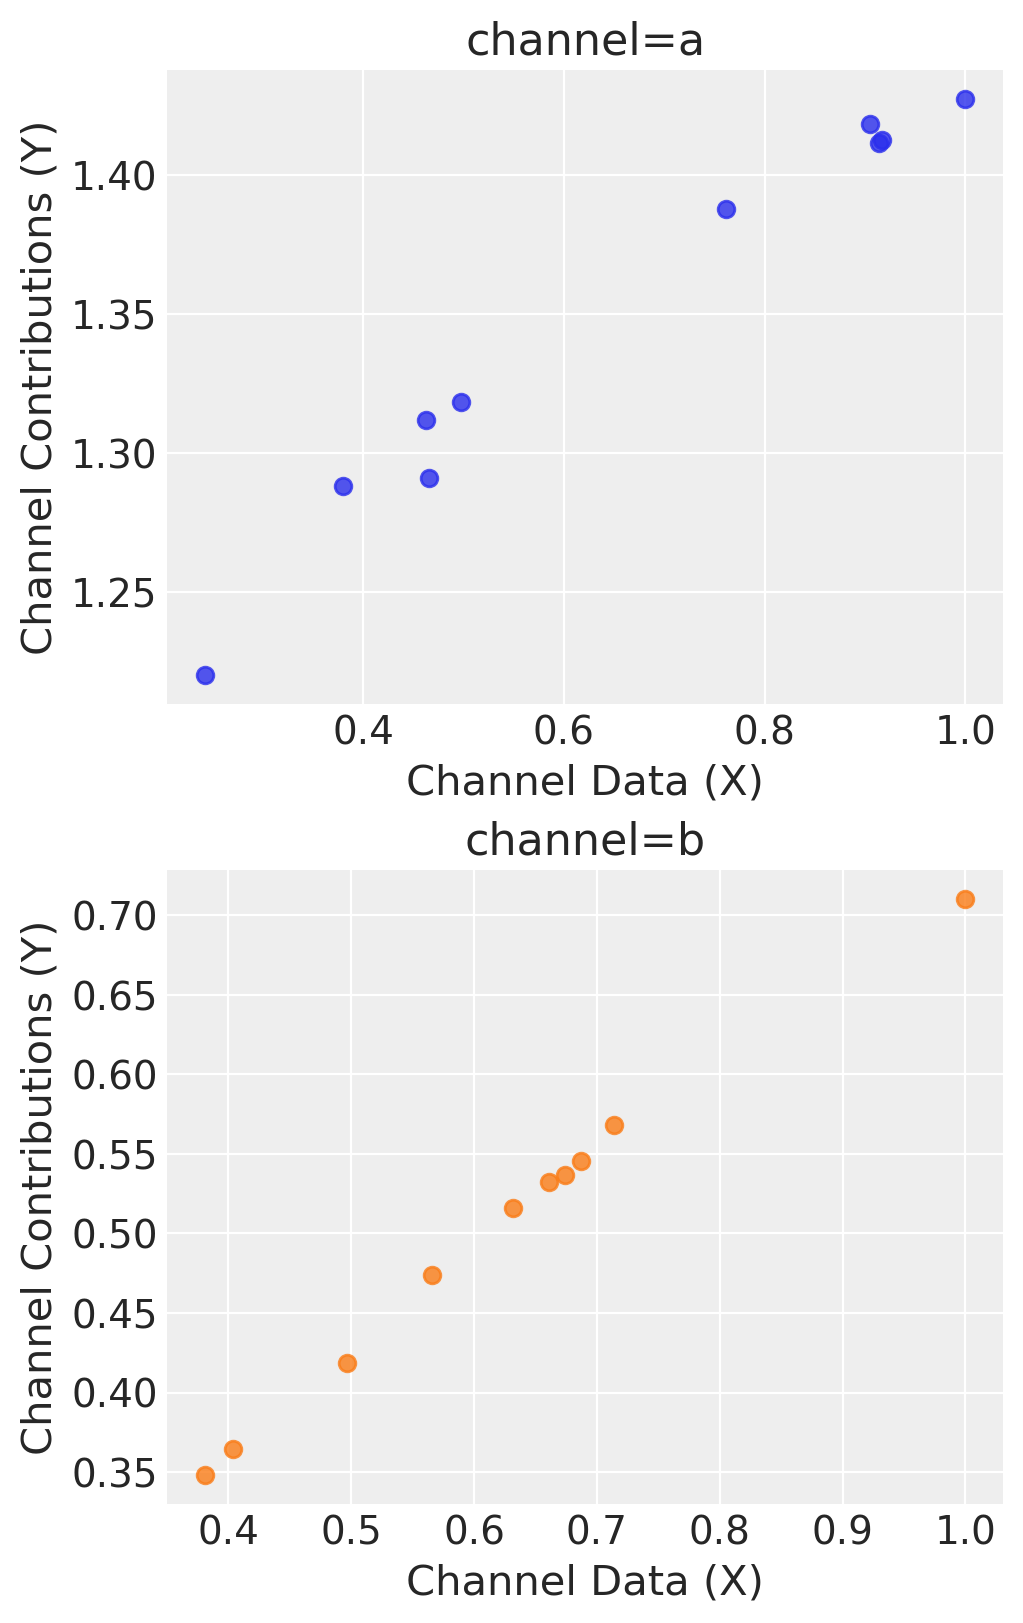

In [22]:
mmm.plot_saturation_curves_scatter();